# 1D Three Phase Simulation of Alloys and PINN model development 


This notebook contains the simulation of 1D Phase change of aluminium alloy. There will be three phases (solid,liquid and mushy).   

The approach used is finite difference method and the physics involved in heat conduction.

## Import Libraries

In [23]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SubsetRandomSampler, random_split

from pinn_loss import loss_fn_data, l1_regularization, pde_loss, boundary_loss, ic_loss, accuracy
from Input_vec_gen import input_gen


## Simulation

### Define the constants and inital geometric domain

In [24]:
# Geometry
length = 15.0e-3             # Length of the rod

# Material properties
rho = 2300.0                     # Density of AL380 (kg/m^3)
rho_l = 2460.0                   # Density of AL380 (kg/m^3)
rho_s = 2710.0                    # Density of AL380 (kg/m^3)
rho_m = (rho_l + rho_s )/2       # Desnity in mushy zone is taken as average of liquid and solid density

k = 104.0                       # W/m-K
k_l = k                       # W/m-K
k_s = 96.2                    # W/m-K
k_m =  (k_l+k_s)/2                     # W/m-K
k_mo = 41.5


cp = 1245.3                      # Specific heat of aluminum (J/kg-K)
cp_l = cp                      # Specific heat of aluminum (J/kg-K)
cp_s = 963.0                 # Specific heat of aluminum (J/kg-K)
cp_m =  (cp_l+cp_s)/2                 # Specific heat of mushy zone is taken as average of liquid and solid specific heat
# cp_m = cp
           # Thermal diffusivity
alpha_l = k_l / (rho_l * cp_l) 
alpha_s = k_s / (rho_s*cp_s)
alpha_m = k_m / (rho_m * cp_m)          #`Thermal diffusivity in mushy zone is taken as average of liquid and solid thermal diffusivity`


#L_fusion = 3.9e3                 # J/kg
L_fusion = 389.0e3               # J/kg  # Latent heat of fusion of aluminum
         # Thermal diffusivity


T_L = 574.4 +273.0                       #  K -Liquidus Temperature (615 c) AL 380
T_S = 497.3 +273.0                     # K- Solidus Temperature (550 C)
m_eff =(k_m/(rho_m*(cp_m + (L_fusion/(T_L-T_S)))))
print (f"alpha_l = {alpha_l}, alpha_s = {alpha_s}, m_eff = {m_eff}")

# htc = 10.0                   # W/m^2-K
# q = htc*(919.0-723.0)
# q = 10000.0


num_points = 50                        # Number of spatial points
dx = length / (num_points - 1)         # Distance between two spatial points
print('dx is',dx)

                                                              
# Time Discretization  
# 
time_end = 40        # seconds                         

maxi = max(alpha_s,alpha_l,alpha_m)
dt = abs(0.5*((dx**2) /maxi)) 

print('dt is ',dt)
num_steps = round(time_end/dt)
print('num_steps is',num_steps)
cfl = 0.5 *(dx**2/max(alpha_l,alpha_s,alpha_m))
print('cfl is',cfl)

time_steps = np.linspace(0, time_end, num_steps + 1)
step_coeff = dt / (dx ** 2)

if dt <= cfl:
    print('stability criteria satisfied')
else:
    print('stability criteria not satisfied')
    sys.exit()

alpha_l = 3.394878564540885e-05, alpha_s = 3.686205086349929e-05, m_eff = 6.296953764744878e-06
dx is 0.0003061224489795918
dt is  0.0012711033647622566
num_steps is 31469
cfl is 0.0012711033647622566
stability criteria satisfied


### Initial and Boundary Conditions

In [25]:

temp_init = 919.0
# Initial temperature and phase fields
temperature = np.full(num_points+2, 919.0)            # Initial temperature of the rod with ghost points at both ends
phase = np.zeros(num_points+2)*0.0                    # Initial phase of the rod with ghost points at both ends

# Set boundary conditions
# temperature[-1] = 919.0 
phase[-1] = 1.0

# temperature[0] = 919.0 #(40 C)
phase[0] = 1.0

# Store initial state in history
temperature_history = [temperature.copy()]    # List to store temperature at each time step
phi_history = [phase.copy()]                    # List to store phase at each time step
temp_init = temperature.copy()                 # Initial temperature of the rod
# print(temperature_history,phi_history)
# Array to store temperature at midpoint over time
midpoint_index = num_points // 2                          # Index of the midpoint

midpoint_temperature_history = [temperature[midpoint_index]]            # List to store temperature at midpoint over time
dm = 60.0e-3                                                            # die thickness in m

# r_m =  (k_mo / dm) + (1/htc)

t_surr = 500.0                                        # Surrounding temperature in K
# t_surr = h()

def kramp(temp,v1,v2,T_L,T_s):                                      # Function to calculate thermal conductivity in Mushy Zone
        slope = (v1-v2)/(T_L-T_S)
        if temp > T_L:
            k_m = k_l
        elif temp < T_S:
            k_m = k_s
        else:
            k_m = k_s + slope*(temp-T_S)
        return k_m

def cp_ramp(temp,v1,v2,T_L,T_s):                                    # Function to calculate specific heat capacity in Mushy Zone
    slope = (v1-v2)/(T_L-T_S)
    if temp > T_L:
        cp_m = cp_l
    elif temp < T_S:
        cp_m = cp_s
    else:
        cp_m = cp_s + slope*(temp-T_S)
    return cp_m

def rho_ramp(temp,v1,v2,T_L,T_s):                                       # Function to calculate density in Mushy Zone
    slope = (v1-v2)/(T_L-T_S)
    if temp > T_L:
        rho_m = rho_l
    elif temp < T_S:
        rho_m = rho_s
    else:
        rho_m = rho_s + slope*(temp-T_S)
    return rho_m

### Solving the HT equation and phase change numerically

In [26]:

for m in range(1, num_steps+1):                                                                            # time loop
    htc = 10.0                   # htc of Still air in W/m^2-K
    q1 = htc*(temp_init[0]-t_surr)   # Heat flux at the left boundary
    
    # print(f"q1 is {q1}")
    temperature[0] = temp_init[0] + alpha_l * step_coeff * ((2.0*temp_init[1]) - (2.0 * temp_init[0])-(2.0*dx*(q1)))  # Update boundary condition temperature
    
    q2 = htc*(temp_init[-1]-t_surr)                   # Heat flux at the right boundary
    temperature[-1] = temp_init[-1] + alpha_l * step_coeff * ((2.0*temp_init[-2]) - (2.0 * temp_init[-1])-(2.0*dx*(q2)))  # Update boundary condition temperature
    
    for n in range(1,num_points+1):              # space loop, adjusted range
       
        if temperature[n] >= T_L:
            temperature[n] += ((alpha_l * step_coeff) * (temp_init[n+1] - (2.0 * temp_init[n]) + temp_init[n-1]))
            phase[n] = 0
            
            # print(f" Time-Step{m},Spatial point{n},Temperature{temperature[n]}")
        elif T_S < temperature[n] < T_L:
            
            k_m = kramp(temperature[n],k_l,k_s,T_L,T_S)
            cp_m = cp_ramp(temperature[n],cp_l,cp_s,T_L,T_S)
            rho_m = rho_ramp(temperature[n],rho_l,rho_s,T_L,T_S)
            m_eff =(k_m/(rho_m*(cp_m + (L_fusion/(T_L-T_S)))))
            
            temperature[n] += ((m_eff * step_coeff)* (temp_init[n+1] - (2.0 * temp_init[n]) + temp_init[n-1]))
            
            phase[n] = (T_L - temperature[n]) / (T_L - T_S)
            # print(m,n,temperature[n],phase[n])
         
        elif temperature[n]<T_S:
            temperature[n] += ((alpha_s * step_coeff) * (temp_init[n+1] - (2.0 * temp_init[n])+ temp_init[n-1]))
            phase[n] = 1
                     
        else:
            print("ERROR: should not be here")

     
          
    temperature = temperature.copy()                                                                # Update temperature
    phase = phase.copy()                                                                            # Update phase
    temp_init = temperature.copy()                                                                  # Update last time step temperature
    temperature_history.append(temperature.copy())                                                  # Append the temperature history to add ghost points
    phi_history.append(phase.copy())                                                                # Append the phase history to add ghost points
    midpoint_temperature_history.append(temperature[midpoint_index])                                # Store midpoint temperature
    
    
    # print(f"Step {m}, Temperature: {temperature}")
    


# print(midpoint_temperature_history)
#print(phi_history)





### Plot the Results

In [27]:
# # Plot temperature history for debugging
# temperature_history_1 = np.array(temperature_history)
# print(temperature_history_1.shape)
# time_ss= np.linspace(0, time_end, num_steps+1)
# # print(time_ss.shape)
# plt.figure(figsize=(10, 6))
# plt.plot(time_ss, midpoint_temperature_history, label='Midpoint Temperature')
# plt.axhline(y=T_L, color='r', linestyle='--', label='Liquidus Temperature')
# plt.axhline(y=T_S, color='g', linestyle='--', label='Solidus Temperature')
# plt.xlabel('Time(s)')
# plt.ylabel('Temperature (K)')
# plt.title('Temperature Distribution Over Time at x = 7.5mm') 
# plt.legend()
# plt.show()

### Data into Array

In [28]:
temperature_history = np.array(temperature_history)

phi_history = np.array(phi_history)

t_hist = np.array(temperature_history[:,1:-1]) # Remove ghost points
t_hist_2 = np.array(temperature_history[:,1:-1])
p_hist = np.array(phi_history[:,1:-1])

t_hist_pde = t_hist[1:,1:-1] # Remove initial condition and boudnary condition
t_hist_init = t_hist[0,:] # Initial condition
t_hist_bc_l = t_hist[:,0] # Left boundary condition
t_hist_bc_r = t_hist[:,-1] # Right boundary condition




In [29]:
# Assuming you have temperature_history and phi_history as lists of arrays


# # Check the new shape after transposing
# print("Transposed Temperature History Shape:", temperature_history.shape)
# print("Transposed Phi History Shape:", phi_history.shape)

# # Create a meshgrid for space and time coordinates
# space_coord, time_coord = np.meshgrid(np.arange(temperature_history.shape[1]), np.arange(temperature_history.shape[0]))

# time_coord = time_coord * dt 
# # Create a figure with two subplots
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# # Plot the temperature history on the left subplot
# im1 = ax1.pcolormesh(space_coord, time_coord, temperature_history, cmap='viridis')
# ax1.set_xlabel('Space Coordinate', fontname='Times New Roman', fontsize=16)
# ax1.set_ylabel('Time',fontname='Times New Roman', fontsize=16)
# ax1.set_title('Temperature Variation Over Time',fontname='Times New Roman', fontsize=20)
# fig.colorbar(im1, ax=ax1, label='Temperature')

# # Plot the phase history on the right subplot
# im2 = ax2.pcolormesh(space_coord, time_coord, phi_history, cmap='viridis')
# ax2.set_xlabel('Space Coordinate', fontname='Times New Roman', fontsize=18)
# ax2.set_ylabel('Time',fontname='Times New Roman', fontsize=16)
# ax2.set_title('Phase Variation Over Time',fontname='Times New Roman', fontsize=20)
# fig.colorbar(im2, ax=ax2, label='Phase')
# plt.tight_layout()
# plt.show()

# #plot the main
# fig, ax = plt.subplots(figsize=(14, 6))
# im = ax.pcolormesh(space_coord, time_coord, Dim_ny, cmap='viridis')
# ax.set_xlabel('Space Coordinate')
# ax.set_ylabel('Time')
# ax.set_title('Niyama Variation Over Time')
# fig.colorbar(im, ax=ax, label='Main')
# plt.tight_layout()
# plt.show()

## ML training

### GPU/CPU check

In [30]:
# check for gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device2 = torch.device('cpu')
print('Using device:', device)



Using device: cuda


### Data preparation

### Main Dataset

In [31]:
scaler = StandardScaler()


space = np.linspace(0, length, num_points) # Spatial points
time = np.linspace(0, time_end, num_steps+1) # Time points
space_tr = scaler.fit_transform(space.reshape(-1, 1)).flatten()
time_tr = scaler.fit_transform(time.reshape(-1, 1)).flatten()

space_pde = space[1:-1] # Remove boundary points
time_pde = time[1:] # Remove initial condition
space_pde_tr = space_tr[1:-1] # Remove boundary points
time_pde_tr = time_tr[1:] # Remove initial condition

sp_i = np.linspace(0, length, num_points) # Spatial points for initial condition
time_i = np.zeros(num_points) # Time points for initial condition
sp_i_tr = scaler.fit_transform(sp_i.reshape(-1, 1)).flatten()
time_i_tr = scaler.fit_transform(time_i.reshape(-1, 1)).flatten()

sp_b_l = np.zeros(num_steps+1) # Spatial points for boundary condition left
time_b_l = np.linspace(0, time_end, num_steps+1) # Time points for boundary condition left
sp_b_l_tr = scaler.fit_transform(sp_b_l.reshape(-1, 1)).flatten()
time_b_l_tr = scaler.fit_transform(time_b_l.reshape(-1, 1)).flatten()

sp_b_r = np.ones(num_steps+1)*length # Spatial points for boundary condition right
time_b_r = np.linspace(0, time_end, num_steps+1) # Time points for boundary condition right
sp_b_r_tr = scaler.fit_transform(sp_b_r.reshape(-1, 1)).flatten()
time_b_r_tr = scaler.fit_transform(time_b_r.reshape(-1, 1)).flatten()



In [32]:

inputs = input_gen(space,time,'mgrid') # Generate input for the model
inputs_pde = input_gen(space_pde,time_pde,'mgrid') # Generate input for the PDE
inputs_i = input_gen(sp_i,time_i,'scr') # Generate input for the initial condition
inputs_b_l = input_gen(sp_b_l,time_b_l,'scr') # Generate input for the boundary condition left
inputs_b_r = input_gen(sp_b_r,time_b_r,'scr') # Generate input for the boundary condition right

# t_hist_tr = scaler.fit_transform(t_hist.reshape(-1,1))
# t_hist_pde_tr = scaler.fit_transform(t_hist_pde.reshape(-1,1))
# t_hist_init_tr = scaler.fit_transform(t_hist_init.reshape(-1,1))
# t_hist_bc_l_tr = scaler.fit_transform(t_hist_bc_l.reshape(-1,1))
# t_hist_bc_r_tr = scaler.fit_transform(t_hist_bc_r.reshape(-1,1))

t_hist_tr = t_hist.reshape(-1,1)
t_hist_pde_tr = t_hist_pde.reshape(-1,1)
t_hist_init_tr = t_hist_init.reshape(-1,1)
t_hist_bc_l_tr = t_hist_bc_l.reshape(-1,1)
t_hist_bc_r_tr = t_hist_bc_r.reshape(-1,1)


In [33]:
print(inputs.shape,inputs_pde.shape,inputs_i.shape,inputs_b_l.shape,inputs_b_r.shape)
# print(t_hist_tr.shape,t_hist_pde_tr.shape,t_hist_init_tr.shape,t_hist_bc_l_tr.shape,t_hist_bc_r_tr.shape)

(1573500, 2) (1510512, 2) (50, 2) (31470, 2) (31470, 2)


## Sample from the Main dataset

In [34]:
def Sampler (x,t,samp_size):
    index = np.random.choice(x.shape[0],samp_size,replace=False)
    return x[index] , t[index]

inputs_sample, t_hist_sample = Sampler(inputs,t_hist_tr,10000) # Sample the input and output data
inputs_pde_sample, t_hist_pde_sample = Sampler(inputs_pde,t_hist_pde_tr,3000) # Sample the input and output data for pde 
inputs_i_sample,t_hist_i_sample = Sampler(inputs_i,t_hist_init_tr,50) # Sample the input and output data for initial condition
inputs_b_l_sample,t_hist_bc_l_sample = Sampler(inputs_b_l,t_hist_bc_l_tr,2000) # Sample the input and output data for boundary condition left
inputs_b_r_sample, t_hist_bc_r_sample = Sampler(inputs_b_r,t_hist_bc_r_tr, 2000) # Sample the input and output data for boundary condition right

print(inputs_sample.shape, t_hist_sample.shape)
print(inputs_pde_sample.shape, t_hist_pde_sample.shape)
print(inputs_i_sample.shape, t_hist_i_sample.shape)
print(inputs_b_l_sample.shape, t_hist_bc_l_sample.shape)
print(inputs_b_r_sample.shape, t_hist_bc_r_sample.shape)

(10000, 2) (10000, 1)
(3000, 2) (3000, 1)
(50, 2) (50, 1)
(2000, 2) (2000, 1)
(2000, 2) (2000, 1)


### Tensor the sample dataset

In [35]:


inputs_sample = torch.tensor(inputs_sample).float().to(device) # Convert the inputs to a tensor
inputs_pde_sample = torch.tensor(inputs_pde_sample).float().to(device) # Convert the inputs to a tensor
inputs_i_sample = torch.tensor(inputs_i_sample).float().to(device) # Convert the inputs to a tensor
inputs_b_l_sample = torch.tensor(inputs_b_l_sample).float().to(device)# Convert the inputs to a tensor
inputs_b_r_sample = torch.tensor(inputs_b_r_sample).float().to(device)# Convert the inputs to a tensor

print(inputs_sample.shape)
# label/temp data
temp_inp_sample = torch.tensor(t_hist_sample).float().to(device) # Convert the temperature history to a tensor
temp_inp_pde_sample = torch.tensor(t_hist_pde_sample).float().to(device) # Convert the temperature history to a tensor
temp_inp_init_sample = torch.tensor(t_hist_i_sample).float().to(device) # Convert the temperature history to a tensor
temp_inp_bc_l_sample = torch.tensor(t_hist_bc_l_sample).float().to(device)# Convert the temperature history to a tensor
temp_inp_bc_r_sample = torch.tensor(t_hist_bc_r_sample).float().to(device)# Convert the temperature history to a tensor

print(temp_inp_sample.shape)




torch.Size([10000, 2])
torch.Size([10000, 1])


In [36]:


#Data Splitting

# train_inputs, val_test_inputs, train_temp_inp, val_test_temp_inp = train_test_split(inputs, temp_inp, test_size=0.2, random_state=42)
# val_inputs, test_inputs, val_temp_inp, test_temp_inp = train_test_split(val_test_inputs, val_test_temp_inp, test_size=0.8, random_state=42)

train_inputs_sample, test_inputs_sample, \
    train_temp_inp_sample, test_temp_inp_sample = \
        train_test_split(inputs_sample, temp_inp_sample,\
                           test_size=0.2, random_state=42)
train_inputs_pde_sample, test_inputs_pde_sample, \
    train_temp_inp_pde_sample, test_temp_inp_pde_sample = \
        train_test_split(inputs_pde_sample, \
                            temp_inp_pde_sample, test_size=0.2, random_state=42)
train_inputs_i_sample, test_inputs_i_sample, \
    train_temp_inp_i_sample, test_temp_inp_i_sample = \
        train_test_split(inputs_i_sample, \
                         temp_inp_init_sample, test_size=0.2, random_state=42)
train_inputs_bc_l_sample, test_inputs_bc_l_sample, \
    train_temp_inp_bc_l_sample, test_temp_inp_bc_l_sample = \
        train_test_split(inputs_b_l_sample, \
                            temp_inp_bc_l_sample, test_size=0.2, random_state=42)
train_inputs_bc_r_sample, test_inputs_bc_r_sample, \
    train_temp_inp_bc_r_sample, test_temp_inp_bc_r_sample = \
        train_test_split(inputs_b_r_sample, temp_inp_bc_r_sample, \
                                    test_size=0.2, random_state=42)




### Create Data loader

In [37]:
class TensorDataset(torch.utils.data.Dataset):
    def __init__(self, inputs,temp_inp,transform=None, target_transform =None):
        
        self.inputs = inputs
        self.temp_inp = temp_inp
               

    def __getitem__(self, index):
        return self.inputs[index], self.temp_inp[index]
    
    def __len__(self):
        return len(self.inputs)


In [38]:

  
train_dataset = TensorDataset(train_inputs_sample, train_temp_inp_sample) # Create the training dataset
# val_dataset = TensorDataset(val_inputs, val_temp_inp) # Create the validation dataset
test_dataset = TensorDataset(test_inputs_sample, test_temp_inp_sample) # Create the test dataset

train_pde_dataset = TensorDataset(train_inputs_pde_sample, train_temp_inp_pde_sample) # Create the training dataset
test_pde_dataset = TensorDataset(test_inputs_pde_sample, test_temp_inp_pde_sample) # Create the test dataset

train_dataset_i = TensorDataset(train_inputs_i_sample, train_temp_inp_i_sample) # Create the training dataset
test_dataset_i = TensorDataset(test_inputs_i_sample, test_temp_inp_i_sample) # Create the test dataset

train_dataset_bc_l = TensorDataset(train_inputs_bc_l_sample, train_temp_inp_bc_l_sample) # Create the training dataset
test_dataset_bc_l = TensorDataset(test_inputs_bc_l_sample, test_temp_inp_bc_l_sample) # Create the test dataset

train_dataset_bc_r = TensorDataset(train_inputs_bc_r_sample, train_temp_inp_bc_r_sample) # Create the training dataset
test_dataset_bc_r = TensorDataset(test_inputs_bc_r_sample, test_temp_inp_bc_r_sample) # Create the test dataset


batch_size = 64
batch_size_init_2 = 5

random_sampler_train = RandomSampler(train_dataset, replacement=True, num_samples=batch_size) # Create a random sampler for the training dataset
# # random_sampler_val = RandomSampler(val_dataset, replacement=True, num_samples=batch_size) # Create a random sampler for the validation dataset
random_sampler_test = RandomSampler(test_dataset, replacement=True, num_samples=batch_size) # Create a random sampler for the test dataset

random_sampler_train_pde = RandomSampler(train_pde_dataset, replacement=True, num_samples=batch_size) # Create a random sampler for the training dataset
random_sampler_test_pde = RandomSampler(test_pde_dataset, replacement=True, num_samples=batch_size) # Create a random sampler for the test dataset

random_sampler_train_i = RandomSampler(train_dataset_i, replacement=True, num_samples=batch_size_init_2) # Create a random sampler for the training dataset
random_sampler_test_i = RandomSampler(test_dataset_i, replacement=True, num_samples=batch_size_init_2) # Create a random sampler for the test dataset

random_sampler_train_bc_l = RandomSampler(train_dataset_bc_l, replacement=True, num_samples=batch_size) # Create a random sampler for the training dataset
random_sampler_test_bc_l = RandomSampler(test_dataset_bc_l, replacement=True, num_samples=batch_size) # Create a random sampler for the test dataset
random_sampler_train_bc_r = RandomSampler(train_dataset_bc_r, replacement=True, num_samples=batch_size) # Create a random sampler for the training dataset
random_sampler_test_bc_r = RandomSampler(test_dataset_bc_r, replacement=True, num_samples=batch_size) # Create a random sampler for the test dataset





train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=random_sampler_train) # Create the training dataloader



# val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=random_sampler_val) # Create the validation dataloader
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler= random_sampler_test) # Create the test dataloader

train_pde_loader = DataLoader(train_pde_dataset, batch_size=batch_size, \
                              sampler=random_sampler_train_pde) # Create the training dataloader
test_pde_loader = DataLoader(test_pde_dataset, batch_size=batch_size,\
                              sampler=random_sampler_test_pde) # Create the test dataloader


train_loader_init = DataLoader(train_dataset_i, batch_size=batch_size_init_2, \
                               sampler=random_sampler_train_i) # Create the training dataloader
test_loader_init = DataLoader(test_dataset_i, batch_size=batch_size_init_2, \
                              sampler=random_sampler_test_i) # Create the test dataloader

train_loader_bc_l = DataLoader(train_dataset_bc_l, batch_size=batch_size, \
                               sampler=random_sampler_train_bc_l) # Create the training dataloader
test_loader_bc_l = DataLoader(test_dataset_bc_l, batch_size=batch_size, \
                              sampler=random_sampler_test_bc_l) # Create the test dataloader
train_loader_bc_r = DataLoader(train_dataset_bc_r, batch_size=batch_size, \
                                sampler=random_sampler_train_bc_r) # Create the training dataloader
test_loader_bc_r = DataLoader(test_dataset_bc_r, batch_size=batch_size, \
                              sampler=random_sampler_test_bc_r) # Create the test dataloader



### NN Architecture Definition

In [39]:

# Define the neural network architecture
class Mushydata(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_lyrs): # This is the constructor
        super(Mushydata, self).__init__()
        
        layers = []

        #input layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        #hidden layer
        for k in range(num_hidden_lyrs):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())    

        #output layer
        layers.append(nn.Linear(hidden_size, output_size))

        # Cnvert the layers list into a pytorch sequential model
        self.base = nn.Sequential(*layers)

    def forward(self, x,t):
        #Concate the input and output to get the final output
        input_features = torch.cat([x,t], dim=1)
        # Pass through sequential layers
        output = self.base(input_features)
        return output
# features = torch.rand(1, 2)
# model = HeatPINN(2, 20, 1)
# output = model(features[:, 0:1], features[:, 1:2])
# print(output)


# Loss function for data 


### Hyperparamters Init

In [40]:
# Hyperparameters
hidden_size = 50
learning_rate = 0.004
num_hidden_lyrs = 3
epochs = 30000
# alpha = 0.01  # Adjust this value based on your problem
# boundary_value = 313.0
# initial_value = init_temp
# Initialize the model
model = Mushydata(input_size=2, hidden_size=hidden_size,output_size=1,num_hidden_lyrs=num_hidden_lyrs).to(device)
lambd = 0.1

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



### Loss List Init

In [41]:
train_losses = []
val_losses = []
test_losses = []

print(f"Datatype of train_loader is {type(train_loader)}")

Datatype of train_loader is <class 'torch.utils.data.dataloader.DataLoader'>


### Loss functions

### Training, Validation and Testing Module

In [42]:
def training_loop(epochs, model, loss_fn_data, optimizer, train_loader,test_dataloader,\
                  train_pde_loader,train_loader_init,\
                    train_loader_bc_l,train_loader_bc_r):
    train_losses = []  # Initialize the list to store the training losses
    # val_losses = []    # Initialize the list to store the validation losses
    test_losses = []   # Initialize the list to store the test losses
    data_losses = []   # Initialize the list to store the data losses
    pde_losses = []   # Initialize the list to store the PDE losses
    ic_losses = []   # Initialize the list to store the initial condition losses
    bc_losses = []   # Initialize the list to store the boundary condition losses

    for epoch in range(epochs):
        model.train()                                                                           # Set the model to training mode
        train_loss = 0                                                                              # Initialize the training loss
        train_accuracy = 0
        train_data_loss = 0
        train_pd_loss = 0
        train_initc_loss = 0
        train_bc_loss = 0

        
        for (batch,batch_pde,batch_init,batch_left,batch_right) in \
             zip (train_loader,train_pde_loader,train_loader_init,train_loader_bc_l,train_loader_bc_r):                                                          # Loop through the training dataloader
            
            train_inputs_sample, train_temp_inp_sample= batch                                                             # Get the inputs and the true values
            
            train_pde_sample, train_temp_inp_pde_sample= batch_pde                                                             # Get the inputs and the true values
            
            train_inputs_i_sample, train_temp_inp_i_sample= batch_init                                                             # Get the inputs and the true values 
            
            train_inputs_bc_l_sample, train_temp_inp_bc_l_sample= batch_left                                                             # Get the inputs and the true values
            train_inputs_bc_r_sample, train_temp_inp_bc_r_sample= batch_right                                                             # Get the inputs and the true values

            train_inputs_sample, train_temp_inp_sample= train_inputs_sample.to(device), train_temp_inp_sample.to(device)                                                             # Get the inputs and the true values
            
            train_pde_sample, train_temp_inp_pde_sample= train_pde_sample.to(device), train_temp_inp_pde_sample.to(device)                                                             # Get the inputs and the true values
            
            train_inputs_i_sample, train_temp_inp_i_sample= train_inputs_i_sample.to(device), train_temp_inp_i_sample.to(device)                                                            # Get the inputs and the true values 
            
            train_inputs_bc_l_sample, train_temp_inp_bc_l_sample=  train_inputs_bc_l_sample.to(device), train_temp_inp_bc_l_sample.to(device)                                                            # Get the inputs and the true values
            train_inputs_bc_r_sample, train_temp_inp_bc_r_sample= train_inputs_bc_r_sample.to(device), train_temp_inp_bc_r_sample.to(device)
            
            
            # print(inputs.shape)
            # print(inputs_init.shape)
            # print(inputs_left.shape)
            # print(inputs_right.shape)

            optimizer.zero_grad()                                                                    # Zero the gradients
            
            # Forward pass
            u_pred = model(train_inputs_sample[:,0].unsqueeze(1), train_inputs_sample[:,1].unsqueeze(1))                       # Get the predictions
            u_initl = model(train_inputs_i_sample[:,0].unsqueeze(1), train_inputs_i_sample[:,1].unsqueeze(1))                       # Get the predictions
            u_left = model(train_inputs_bc_l_sample[:,0].unsqueeze(1), train_inputs_bc_l_sample[:,1].unsqueeze(1))               # Left boundary of the temperature
            u_right = model(train_inputs_bc_r_sample[:,0].unsqueeze(1), train_inputs_bc_r_sample[:,1].unsqueeze(1))             # Right boundary of the temperature

            # Loss calculation
            data_loss = loss_fn_data(u_pred, train_temp_inp_sample)                                              # Calculate the data loss
            
            pd_loss = pde_loss(model,train_pde_sample[:,0].unsqueeze(1),train_pde_sample[:,1].unsqueeze(1))             # Calculate the PDE loss
            # pd_loss = 0
            
            initc_loss = ic_loss(u_initl) 
            # initc_loss =0                                                      # Calculate initial condition loss
            
            bc_loss_left = boundary_loss(model,train_inputs_bc_l_sample[:,0].unsqueeze(1),train_inputs_bc_l_sample[:,1].unsqueeze(1),t_surr) # Calculate the left boundary condition loss
            bc_loss_right = boundary_loss(model,train_inputs_bc_r_sample[:,0].unsqueeze(1),train_inputs_bc_r_sample[:,1].unsqueeze(1),t_surr) # Calculate the right boundary condition loss
            bc_loss = bc_loss_left + bc_loss_right
            # l1_regularization_loss = l1_regularization(model, lambda_l1)                      # Calculate the L1 regularization loss
            # loss = data_loss  + pd_loss + initc_loss + bc_loss                                              # Calculate the total loss
            w1 = 0.0001
            w2 = 0.0001
            w3 = 0.0001
            loss = data_loss + w1* pd_loss + w2 *initc_loss + w3* bc_loss
            train_accuracy += accuracy(u_pred, train_temp_inp_sample)                                                              # Calculate the total loss
            # Backpropagation
            loss.backward()                                                        # Backpropagate the gradients
            
            optimizer.step()                                                                           # Update the weights
            
            train_loss += loss.item()                                                           # Add the loss to the training set loss  
            train_data_loss += data_loss.item()
            train_pd_loss += pd_loss.item()
            train_initc_loss += initc_loss.item()
            train_bc_loss += bc_loss.item()
        
        train_losses.append(train_loss)
        data_losses.append(train_data_loss)
        pde_losses.append(train_pd_loss)
        ic_losses.append(train_initc_loss)
        bc_losses.append(train_bc_loss)


        model.eval()
        test_loss = 0
        test_accuracy = 0
        # with torch.no_grad(): 
        for batch in test_dataloader:
            test_inputs_sample, test_temp_inp_sample= batch
            test_inputs_sample, test_temp_inp_sample= test_inputs_sample.to(device), test_temp_inp_sample.to(device)
            u_pred = model(test_inputs_sample[:,0].unsqueeze(1), test_inputs_sample[:,1].unsqueeze(1))
            data_loss_t = loss_fn_data(u_pred, test_temp_inp_sample)
            # l1_regularization_loss = l1_regularization(model, lambd)
            # loss = data_loss  + l1_regularization_loss
            
            loss = data_loss_t
            test_accuracy = accuracy(u_pred, test_temp_inp_sample)
            test_loss += loss.item()
        test_losses.append(test_loss/len(test_dataloader))

                                                           # Append the training loss to the list of training losses
        
        

        torch.cuda.empty_cache()
        if epoch % 100 == 0:
            print(f"Epoch {epoch},| Training-Loss: {train_loss:.4e}| Test-loss: {test_loss:.4e}|")
            
            print(f"|Data-loss: {data_loss:.4e}|Pde-loss: {pd_loss:.4e}| Initc-loss: {initc_loss:.4e}"
                f"|Bc_loss: {bc_loss:.4e}|") 
            print()

    return train_losses, test_losses , pde_losses , bc_losses , ic_losses, data_losses                                                      # Return the training and validation losses


In [43]:
def test_loop(epochs, model, loss_fn_data, optimizer, train_dataloader, test_dataloader):
    for epoch in range(epochs):
        model.eval()
        test_loss = 0
        test_accuracy = 0
        with torch.no_grad():   
            for batch in test_dataloader:
                test_inputs_sample, test_temp_inp_sample= batch
                test_inputs_sample, test_temp_inp_sample= test_inputs_sample.to(device), test_temp_inp_sample.to(device)
                u_pred = model(test_inputs_sample[:,0].unsqueeze(1), test_inputs_sample[:,1].unsqueeze(1))
                data_loss = loss_fn_data(u_pred, test_temp_inp_sample)
                # l1_regularization_loss = l1_regularization(model, lambd)
                # loss = data_loss  + l1_regularization_loss
                
                loss = data_loss
                test_accuracy = accuracy(u_pred, test_temp_inp_sample)
                test_loss += loss.item()
        test_losses.append(test_loss)
        if epochs % 10 == 0:
            print(f"Epoch {epoch}, Test-Loss {test_loss:.4e}, Test-Accuracy {test_accuracy:.4e}")      
    return test_losses

### Training Button 

In [44]:

train_losses, test_losses, pde_losses, bc_losses,ic_losses, data_losses = training_loop(epochs, model, \
                                        loss_fn_data, optimizer,train_loader,test_loader,\
                                            train_pde_loader, train_loader_init,\
                                            train_loader_bc_l,train_loader_bc_r)  # Train the model
 
# test_losses = test_loop(epochs, model, loss_fn_data, optimizer, train_loader, test_loader)  # Test the model


   


    
    

Epoch 0,| Training-Loss: 6.5704e+05| Test-loss: 6.5022e+05|
|Data-loss: 6.5196e+05|Pde-loss: 1.0919e-04| Initc-loss: 8.4430e+05|Bc_loss: 4.9973e+07|

Epoch 100,| Training-Loss: 1.0252e+04| Test-loss: 7.3572e+03|
|Data-loss: 8.9670e+03|Pde-loss: 2.3592e+04| Initc-loss: 4.8754e+04|Bc_loss: 1.2777e+07|

Epoch 200,| Training-Loss: 3.4417e+03| Test-loss: 2.5671e+03|
|Data-loss: 2.0887e+03|Pde-loss: 6.8613e+03| Initc-loss: 2.5829e+04|Bc_loss: 1.3497e+07|

Epoch 300,| Training-Loss: 2.1691e+03| Test-loss: 3.8203e+02|
|Data-loss: 4.9869e+02|Pde-loss: 1.7056e+03| Initc-loss: 1.7794e+04|Bc_loss: 1.6685e+07|

Epoch 400,| Training-Loss: 2.0263e+03| Test-loss: 2.4064e+02|
|Data-loss: 2.6905e+02|Pde-loss: 2.0391e+03| Initc-loss: 1.4923e+04|Bc_loss: 1.7556e+07|

Epoch 500,| Training-Loss: 2.0310e+03| Test-loss: 1.8506e+02|
|Data-loss: 2.3721e+02|Pde-loss: 1.4793e+03| Initc-loss: 1.5304e+04|Bc_loss: 1.7921e+07|

Epoch 600,| Training-Loss: 1.8718e+03| Test-loss: 1.6744e+02|
|Data-loss: 1.3836e+02|Pde-l

(31470, 50)


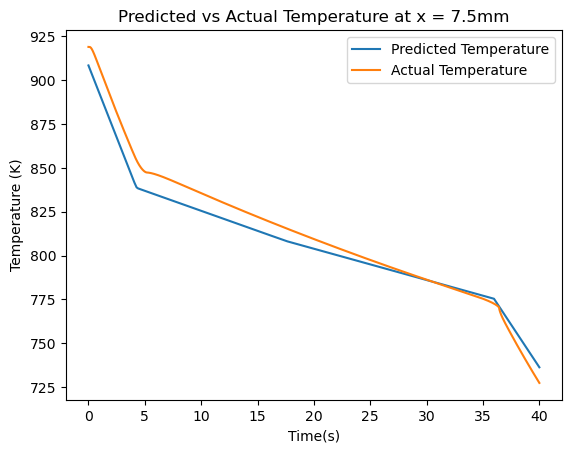

In [45]:
inputs = torch.tensor(inputs).float().to(device) # Convert the inputs to a tensor
temp_nn = model(inputs[:,0].unsqueeze(1), inputs[:,1].unsqueeze(1)).cpu().detach().numpy() # Get the predictions from the model
# temp_nn = scaler.inverse_transform(temp_nn) # Inverse transform the predictions
temp_nn = temp_nn.reshape(num_steps+1, num_points) # Reshape the predictions to a 2D array
print(temp_nn.shape)
time_ss= np.linspace(0, time_end, num_steps+1 )
plt.figure
plt.plot(time_ss, temp_nn[:, num_points//2], label='Predicted Temperature')
plt.plot(time_ss, temperature_history[:,num_points//2], label='Actual Temperature')
plt.xlabel('Time(s)')
plt.ylabel('Temperature (K)')
plt.title('Predicted vs Actual Temperature at x = 7.5mm')
plt.legend()
plt.show()


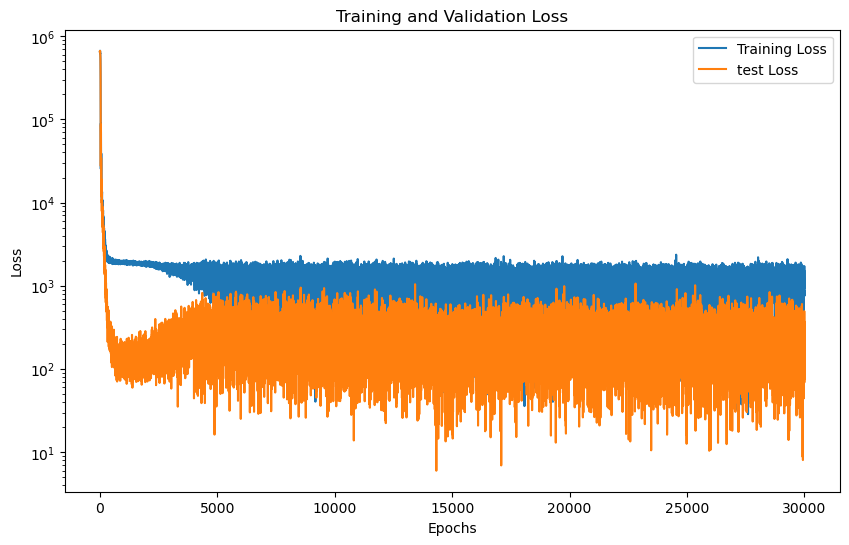

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='test Loss')
# plt.xticks(np.arange(0, epochs, 10000))
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

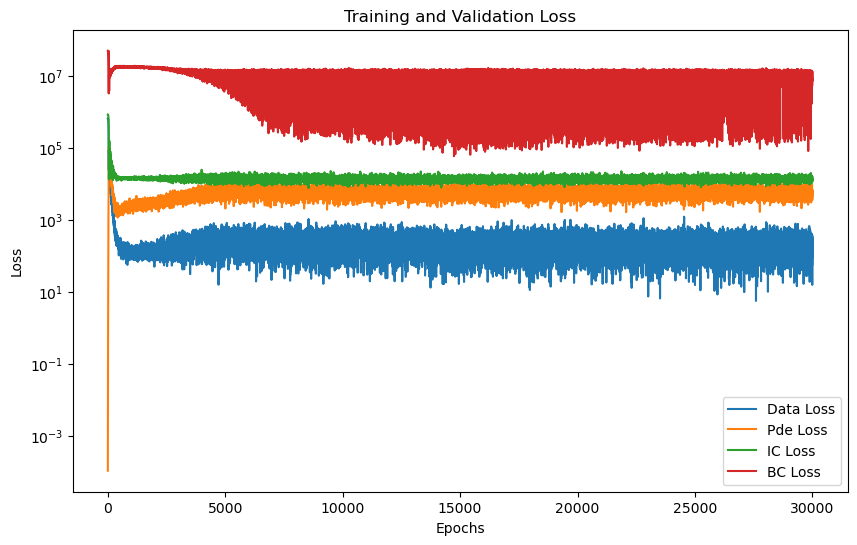

In [47]:
# pde_losses_n = [tensor.cpu().detach().numpy() for tensor in pde_losses]
pde_losses_n = pde_losses 
# data_losses_n = [tensor.cpu().detach().numpy() for tensor in data_losses]
# ic_losses_n = [tensor.cpu().detach().numpy() for tensor in ic_losses]
# bc_losses_n = [tensor.cpu().detach().numpy() for tensor in bc_losses]
data_losses_n = data_losses
ic_losses_n = ic_losses
bc_losses_n = bc_losses


plt.figure(figsize=(10, 6))
plt.plot(data_losses_n, label='Data Loss')
plt.plot(pde_losses_n, label='Pde Loss')
plt.plot(ic_losses_n, label='IC Loss')
plt.plot(bc_losses_n, label='BC Loss')
plt.yscale('log')
# plt.axhline(y=1e-6, color='red', linestyle='--', label='Near-Zero Line')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

(31470, 50) (31470, 50) (31470, 50) (31470, 50)


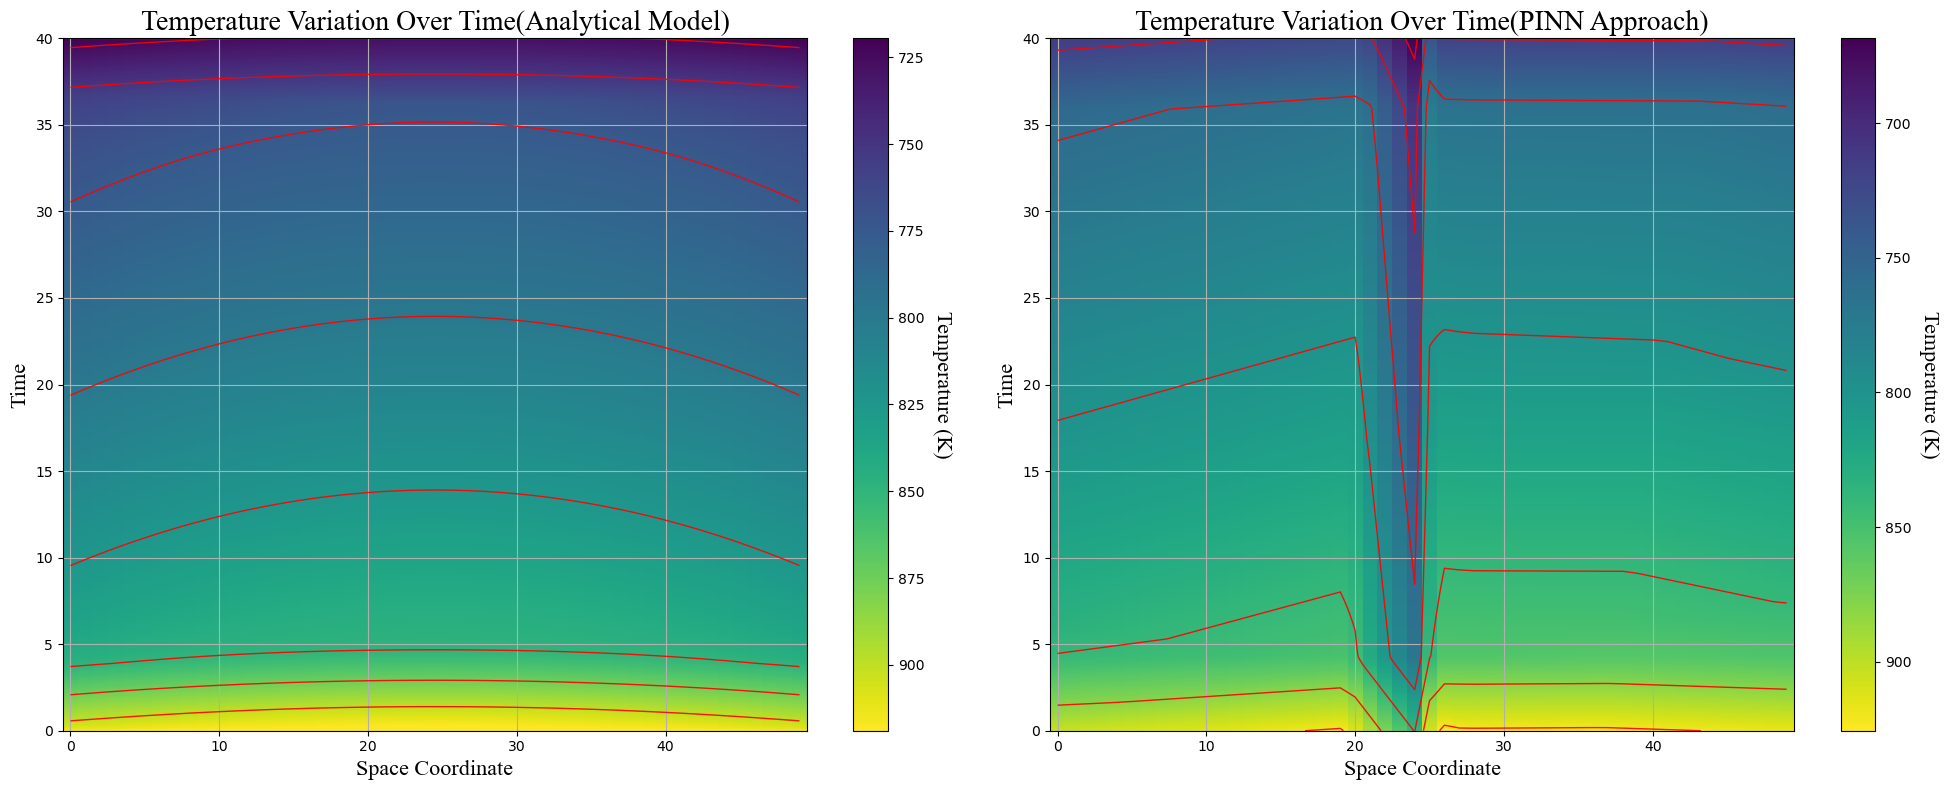

In [48]:
space_coord, time_coord = np.meshgrid(np.arange(t_hist_2.shape[1]), np.arange(t_hist_2.shape[0]))

time_coord = time_coord * dt 
# Create a figure with two subplots
print(space_coord.shape,time_coord.shape,t_hist.shape,temp_nn.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))


# Plot the temperature history on the left subplot
im1 = ax1.pcolormesh(space_coord, time_coord, t_hist_2, cmap='viridis', shading='auto')
ax1.set_xlabel('Space Coordinate', fontname='Times New Roman', fontsize=16)
ax1.set_ylabel('Time',fontname='Times New Roman', fontsize=16)
ax1.set_title('Temperature Variation Over Time(Analytical Model)',fontname='Times New Roman', fontsize=20)
ax1.contour(space_coord, time_coord, t_hist_2, colors='red', linewidths=1.0, alpha=0.9)

ax1.grid(True)
cbar = fig.colorbar(im1, ax=ax1)
cbar.ax.invert_yaxis()
cbar.set_label('Temperature (K)', rotation=270, labelpad=20, fontname='Times New Roman', fontsize=16)

im2 = ax2.pcolormesh(space_coord, time_coord, temp_nn, cmap='viridis', shading='auto')
ax2.set_xlabel('Space Coordinate', fontname='Times New Roman', fontsize=16)
ax2.set_ylabel('Time',fontname='Times New Roman', fontsize=16)
ax2.set_title('Temperature Variation Over Time(PINN Approach)',fontname='Times New Roman', fontsize=20)
ax2.contour(space_coord, time_coord, temp_nn, colors='red', linewidths=1.0, alpha=0.9)

ax2.grid(True)
cbar = fig.colorbar(im2, ax=ax2)
cbar.ax.invert_yaxis()
cbar.set_label('Temperature (K)', rotation=270, labelpad=20, fontname='Times New Roman', fontsize=16)


plt.tight_layout()
plt.show()
